<a href="https://colab.research.google.com/github/juihuichung/dxmi/blob/main/diffusion_by_maximum_entropy_irl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
seed                     = 42          # Random seed for reproducibility

data_size                = (1, 8, 8)   # Shape of input data: (channels, height, width)
limit_samples            = 20000       # Maximum number of samples used during training
label                    = None        # Set to 0,1,...9 or None (include all numbers)
train_batch_size         = 128         # Number of samples per training batch

diffusion_num_timesteps  = 1000        # Total number of timesteps in reverse process and image generation
diffusion_num_epochs     = 10          # Number of epochs for training the diffusion model
diffusion_learning_rate  = 1e-3        # Learning rate for the diffusion model optimizer
diffusion_embedding_size = 100         # Dimensionality of input embeddings in the diffusion model
diffusion_hidden_size    = 512         # Hidden layer size in diffusion model (policy network) MLP
diffusion_hidden_layers  = 5           # Number of hidden layers in the diffusion model

n_reduced_timesteps      = 5           # The reduced timesteps in DxMI
hidden_size_value        = 512         # Hidden layer size in the value network
hidden_layers_value      = 5           # Number of hidden layers in the value network
learning_rate_policy     = 1e-7        # Learning rate for policy network
learning_rate_value      = 1e-6        # Learning rate for value network

dxmi_num_epochs          = 10          # Number of epochs for the DxMI
dxmi_target_network      = False       # Whether to use a target network for stabilization
dxmi_entropy_coef        = 0.0         # Entropy regularization coefficient (encourages exploration)
dxmi_cost_coef           = 0.1         # Coefficient for the cost/loss term associated with predicted values
dxmi_gradient_clipping   = 0.0         # Gradient clipping threshold (0.0 means no clipping)


In [1]:
!pip install torchmetrics[image] scipy torch-fidelity  > /dev/null 2>&1
!pip install numpy==1.26.4
# restart runtime after this, since the VAR_sampling requires numpy==1.26.4

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchmetrics.image.fid import FrechetInceptionDistance

print("... packages loaded", flush=True)

torch.manual_seed(seed)


... packages loaded


In [10]:
def mnist_dataset(train=True, limit_samples=None, data_size=(1, 8, 8), label=None):
    from torchvision.datasets import MNIST
    import torch.nn.functional as F

    train_dataset = MNIST("./data", download=True, train=train)

    data = train_dataset.data.float() / 255.0
    data = (data * 2.0) - 1.0

    target = train_dataset.targets

    data = data.unsqueeze(1)

    target_h, target_w = data_size[1], data_size[2]
    data = F.interpolate(data, size=(target_h, target_w), mode='bilinear', align_corners=False)

    if label is not None:
        mask = (target == label)
        data = data[mask]

    if limit_samples is not None:
        data = data[:limit_samples]
        target = target[:limit_samples]

    return data, target


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ln = nn.LayerNorm(size)
        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(self.ln(x)))


class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        self.emb = nn.Parameter(emb, requires_grad=False)

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        emb = x * self.emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb


class PolicyNet(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128, data_size: tuple = (1, 28, 28)):
        super().__init__()
        self.time_emb = SinusoidalEmbedding(emb_size)

        flattened_dim = data_size[0] * data_size[1] * data_size[2]
        self.concat_size = flattened_dim + emb_size  # concatenating image vector and time embedding
        self.data_dim = flattened_dim

        layers = [nn.Linear(self.concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.LayerNorm(hidden_size))
        layers.append(nn.Linear(hidden_size, self.data_dim))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        original_shape = x.shape
        x_flat = x.reshape(x.shape[0], -1)
        t_emb = self.time_emb(t.reshape(-1, 1))
        x_cat = torch.cat((x_flat, t_emb), dim=-1)
        out = self.joint_mlp(x_cat)
        return out.reshape(original_shape)


class ValueNet(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, data_size: tuple = (1, 28, 28)):
        super().__init__()
        flattened_dim = data_size[0] * data_size[1] * data_size[2]
        layers = [nn.Linear(flattened_dim, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.LayerNorm(hidden_size))
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x_flat = x.reshape(x.shape[0], -1)
        return self.net(x_flat)


class Diffusion(nn.Module):
    # adapted from https://github.com/schinger/DiffusionModel
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super().__init__()
        self.num_timesteps = num_timesteps

        betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)
        sqrt_alphas_cumprod = alphas_cumprod ** 0.5
        sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod) ** 0.5
        sqrt_inv_alphas = torch.sqrt(1.0 / alphas)
        noise_coef = betas / sqrt_one_minus_alphas_cumprod
        variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        buffers = {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'alphas_cumprod_prev': alphas_cumprod_prev,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
            'sqrt_inv_alphas': sqrt_inv_alphas,
            'noise_coef': noise_coef,
            'variance': variance
        }

        for name, tensor in buffers.items():
            self.register_buffer(name, tensor)

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1, 1, 1)
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1, 1, 1)
        result = s1 * x_start + s2 * x_noise
        return result

    def sample_step(self, model_output, timestep, sample):
        s1 = self.sqrt_inv_alphas[timestep].reshape(-1, 1, 1, 1)
        s2 = self.noise_coef[timestep].reshape(-1, 1, 1, 1)
        s3 = self.variance[timestep].reshape(-1, 1, 1, 1) ** 0.5

        noise = torch.randn_like(model_output)
        mask = (timestep == 0).reshape(-1, 1, 1, 1).expand_as(model_output)
        noise = torch.where(mask, torch.zeros_like(noise), noise)

        result = s1 * (sample - s2 * model_output) + s3 * noise
        return result

    def __len__(self):
        return self.num_timesteps


In [11]:
def sample_images(policy_net, diffusion, device, sample_size=10):
    policy_net.eval()
    with torch.no_grad():
        # Start from pure Gaussian noise
        samples = torch.randn(sample_size, *data_size, device=device)
        # Reverse diffusion loop: from timestep num_timesteps-1 down to 0
        for t in reversed(range(num_timesteps)):
            t_tensor = torch.full((sample_size,), t, device=device, dtype=torch.float32)
            policy_output = policy_net(samples, t_tensor)
            samples = diffusion.sample_step(policy_output, t_tensor.long(), samples)
        samples = torch.clamp(samples, -1, 1)
        # samples = ((samples + 1) / 2 * 255).to(torch.uint8)

    return samples # claim to [-1,1]


def compute_fid(policy_net, diffusion, device, sample_size=100, feature=192, sampler=None):
    fid = FrechetInceptionDistance(feature=feature, normalize=True).to(device)

    def preprocess(x):
        x = x.repeat(1,3,1,1)
        x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
        return (x + 1.0)/2.0


    real = train_data[:sample_size].to(device)
    if sampler is not None:
        # use var_sampler
        sampler.eval()
        d_sample = sampler.sample(sample_size, device=device)
        fake = torch.clamp(d_sample['sample'],-1,1)
    else:
        fake = sample_images(policy_net, diffusion, device, sample_size=sample_size)
    # fake = torch.rand_like(real).mul(2).sub(1).to(device)

    fake = torch.clamp(fake, -1,1) # just in case


    real_loader = DataLoader(TensorDataset(real), batch_size=128, shuffle=False)
    fake_loader = DataLoader(TensorDataset(fake), batch_size=128, shuffle=False)

    for (batch,) in real_loader:
        fid.update(preprocess(batch.to(device)), real=True)

    for (batch,) in fake_loader:
        fid.update(preprocess(batch.to(device)), real=False)

    return fid.compute().item()


In [12]:
import datetime
from zoneinfo import ZoneInfo

now = datetime.datetime.now(ZoneInfo("America/New_York"))
now_str = now.strftime("%m%d_%H%M")
print("...", now_str)

# check_file = now.strftime("dxmi_checkpoint_%m%d_%H%M.pth")
# eval_file = now.strftime("dxmi_evaluation_results_%m%d_%H%M.txt")

diffusion_file = now.strftime(f"pretraining_diffusion_results_{now_str}.txt")
log_file       = now.strftime("log_dxmi_%m%d_%H%M.txt")

... 0511_1300


In [13]:
# data_size = (1, 8, 8)
# limit_samples = 20000
# label = None
# train_batch_size = 128


hyperparams = {
    "data_size":   data_size,
    "limit_samples": limit_samples,
    "label": label,
    "train_batch_size": train_batch_size,
    "seed": seed
}

with open(log_file, "a") as f:
    f.write("=== Data info ===\n")
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
    f.write("\n")   # blank line for separation
    f.flush()       # ensure it's written out immediately



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_data, target_data = mnist_dataset(train=True, limit_samples=limit_samples, data_size=data_size, label=label)
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)

print("Length of training data:", len(train_data))

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.51MB/s]


Length of training data: 20000


In [14]:
# Hyperparameters
# learning_rate = 1e-3
# num_epochs = 500
# num_timesteps = 1000
# embedding_size = 100
# hidden_size = 512
# hidden_layers = 5


learning_rate = diffusion_learning_rate
num_epochs = diffusion_num_epochs
num_timesteps = diffusion_num_timesteps
embedding_size = diffusion_embedding_size
hidden_size = diffusion_hidden_size
hidden_layers = diffusion_hidden_layers

hyperparams = {
    "learning_rate":    learning_rate,
    "num_epochs":      num_epochs,
    "num_timesteps":   num_timesteps,
    "embedding_size":  embedding_size,
    "hidden_size": hidden_size,
    "hidden_layers": hidden_layers,
    "device": str(device)
}

with open(log_file, "a") as f:
    f.write("=== Hyperparameters for diffusion model ===\n")
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
    f.write("\n")   # blank line for separation
    f.flush()       # ensure it's written out immediately



policy_net = PolicyNet(hidden_size=hidden_size, hidden_layers=hidden_layers,
            emb_size=embedding_size, data_size=data_size).to(device)
diffusion = Diffusion(num_timesteps=num_timesteps).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    policy_net.train()
    epoch_loss = 0.0
    for (batch_data,) in train_loader:
        x = batch_data.to(device).float()

        optimizer.zero_grad()
        t = torch.randint(0, num_timesteps, (x.size(0),), device=device)
        noise = torch.randn_like(x)
        x_noisy = diffusion.add_noise(x, noise, t)
        predicted_noise = policy_net(x_noisy, t.float())
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    output_line = f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}"
    if epoch == 0 or (epoch+1) % 10 == 0 or (epoch+1) == num_epochs:
        score = compute_fid(policy_net, diffusion, device)
        output_line += f", FID: {score:.6f}"
    print(output_line)
    with open(diffusion_file, 'a') as f:
        f.write(output_line + '\n')
        f.flush()


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 116MB/s]


Epoch 1/10, Loss: 0.266253, FID: 9.894085
Epoch 2/10, Loss: 0.148611
Epoch 3/10, Loss: 0.134554
Epoch 4/10, Loss: 0.129400
Epoch 5/10, Loss: 0.126885
Epoch 6/10, Loss: 0.121043
Epoch 7/10, Loss: 0.113898
Epoch 8/10, Loss: 0.112428
Epoch 9/10, Loss: 0.112234
Epoch 10/10, Loss: 0.109794, FID: 1.115394


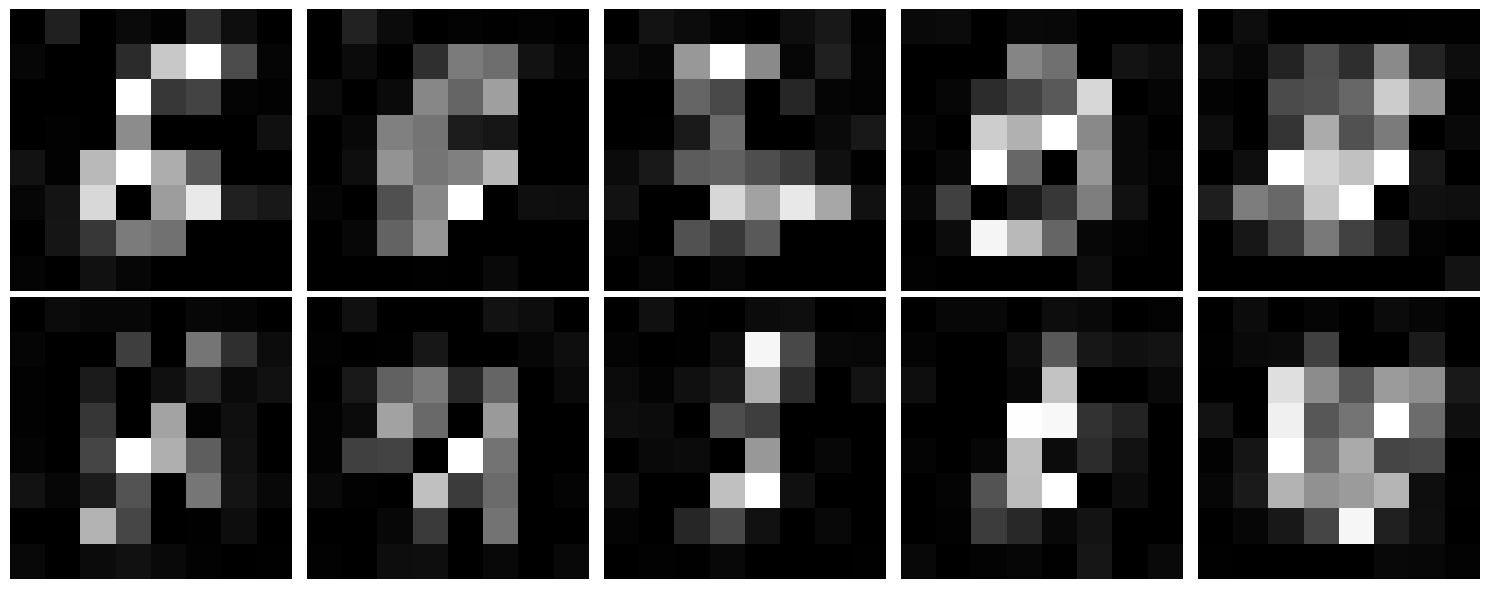

In [15]:
# Generate 10 samples.
samples = sample_images(policy_net, diffusion, device, sample_size=10)

# Set up a 2x5 grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    img = samples[idx]
    img = torch.clamp(img, -1, 1)
    img = ((img + 1) / 2 * 255).to(torch.uint8)
    img = img.permute(1, 2, 0)
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.axis('off')  # Remove axes ticks

plt.tight_layout()
plt.savefig(f'pretrained_images_{now_str}.png')


In [16]:
"""
adopted and refactored from
https://github.com/UW-Madison-Lee-Lab/SFT-PG/blob/main/finetune.py
"""
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal

unsqueeze3x = lambda x: x[..., None, None, None]

diffusion_config = {
    "beta_0": 0.0001,
    "beta_T": 0.02,
    "T": 1000,
}


def process_single_t(x, t):
    """make single integer t into a vector of an appropriate size"""
    if isinstance(t, int) or len(t.shape) == 0 or len(t) == 1:
        t = torch.ones([x.shape[0]], dtype=torch.long, device=x.device) * t
    return t

def calc_diffusion_hyperparams(T, beta_0, beta_T):
    """
    Compute diffusion process hyperparameters

    Parameters:
    T (int):                    number of diffusion steps
    beta_0 and beta_T (float):  beta schedule start/end value,
                                where any beta_t in the middle is linearly interpolated

    Returns:
    a dictionary of diffusion hyperparameters including:
        T (int), Beta/Alpha/Alpha_bar/Sigma (torch.tensor on cpu, shape=(T, ))
    """

    Beta = torch.linspace(beta_0, beta_T, T)
    Alpha = 1 - Beta
    Alpha_bar = Alpha + 0
    Beta_tilde = Beta + 0
    for t in range(1, T):
        Alpha_bar[t] *= Alpha_bar[t-1]
        Beta_tilde[t] *= (1-Alpha_bar[t-1]) / (1-Alpha_bar[t])
    Sigma = torch.sqrt(Beta_tilde)

    _dh = {}
    _dh["T"], _dh["Beta"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Sigma"] = T, Beta, Alpha, Alpha_bar, Sigma
    diffusion_hyperparams = _dh
    return diffusion_hyperparams

def bisearch(f, domain, target, eps=1e-8):
    """
    find smallest x such that f(x) > target

    Parameters:
    f (function):               function
    domain (tuple):             x in (left, right)
    target (float):             target value

    Returns:
    x (float)
    """
    #
    sign = -1 if target < 0 else 1
    left, right = domain
    for _ in range(1000):
        x = (left + right) / 2
        if f(x) < target:
            right = x
        elif f(x) > (1 + sign * eps) * target:
            left = x
        else:
            break
    return x


def get_VAR_noise(S, schedule='linear'):
    """
    Compute VAR noise levels

    Parameters:
    S (int):            approximante diffusion process length
    schedule (str):     linear or quadratic

    Returns:
    np array of noise levels, size = (S, )
    """
    target = np.prod(1 - np.linspace(diffusion_config["beta_0"], diffusion_config["beta_T"], diffusion_config["T"])) # target = alpha_T_bar

    if schedule == 'linear':
        g = lambda x: np.linspace(diffusion_config["beta_0"], x, S)
        domain = (diffusion_config["beta_0"], 0.99)
    elif schedule == 'quadratic':
        g = lambda x: np.array([diffusion_config["beta_0"] * (1+i*x) ** 2 for i in range(S)])
        domain = (0.0, 0.95 / np.sqrt(diffusion_config["beta_0"]) / S)
    else:
        raise NotImplementedError

    f = lambda x: np.prod(1 - g(x))
    largest_var = bisearch(f, domain, target, eps=1e-4)
    return g(largest_var)


def _log_gamma(x):
    # Gamma(x+1) ~= sqrt(2\pi x) * (x/e)^x  (1 + 1 / 12x)
    y = x - 1
    return np.log(2 * np.pi * y) / 2 + y * (np.log(y) - 1) + np.log(1 + 1 / (12 * y))


def _log_cont_noise(t, beta_0, beta_T, T):
    # We want log_cont_noise(t, beta_0, beta_T, T) ~= np.log(Alpha_bar[-1].numpy())
    delta_beta = (beta_T - beta_0) / (T - 1)
    _c = (1.0 - beta_0) / delta_beta
    t_1 = t + 1
    return t_1 * np.log(delta_beta) + _log_gamma(_c + 1) - _log_gamma(_c - t_1 + 1)


# VAR
def _precompute_VAR_steps(diffusion_hyperparams, user_defined_eta, device=None):
    _dh = diffusion_hyperparams
    T, Alpha, Alpha_bar, Beta = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Beta"]
    assert len(Alpha_bar) == T

    # compute diffusion hyperparameters for user defined noise
    T_user = len(user_defined_eta)
    Beta_tilde = torch.from_numpy(user_defined_eta).to(torch.float32).to(device)

    Gamma_bar = 1 - Beta_tilde
    for t in range(1, T_user):
        Gamma_bar[t] *= Gamma_bar[t-1]

    assert Gamma_bar[0] <= Alpha_bar[0] and Gamma_bar[-1] >= Alpha_bar[-1]

    continuous_steps = []
    with torch.no_grad():
        for t in range(T_user-1, -1, -1):
            t_adapted = None
            for i in range(T - 1):
                if Alpha_bar[i] >= Gamma_bar[t] > Alpha_bar[i+1]:
                    t_adapted = bisearch(f=lambda _t: _log_cont_noise(_t, Beta[0].cpu().numpy(), Beta[-1].cpu().numpy(), T),
                                            domain=(i-0.01, i+1.01),
                                            target=np.log(Gamma_bar[t].cpu().numpy()))
                    break
            if t_adapted is None:
                t_adapted = T - 1
            continuous_steps.append(t_adapted)  # must be decreasing
    return continuous_steps


def VAR_get_params(diffusion_hyperparams, user_defined_eta, kappa, continuous_steps):
    """modified to remove map_gpu"""

    _dh = diffusion_hyperparams
    T, Alpha, Alpha_bar, Beta = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Beta"]
    assert len(Alpha_bar) == T
    assert 0.0 <= kappa <= 1.0

    # compute diffusion hyperparameters for user defined noise
    T_user = len(user_defined_eta)
    Beta_tilde = torch.from_numpy(user_defined_eta).to(torch.float32)
    Gamma_bar = 1 - Beta_tilde
    for t in range(1, T_user):
        Gamma_bar[t] *= Gamma_bar[t-1]

    assert Gamma_bar[0] <= Alpha_bar[0] and Gamma_bar[-1] >= Alpha_bar[-1]

    x_prev_multiplier = torch.zeros(T_user)
    theta_multiplier = torch.zeros(T_user)
    std = torch.zeros(T_user)
    diffusion_steps_list = torch.zeros(T_user)


    for i, tau in enumerate(continuous_steps):
        diffusion_steps_list[i] = tau
        if i == T_user - 1:  # the next step is to generate x_0
            # assert abs(tau) < 0.1
            alpha_next = torch.tensor(1.0)
            sigma = torch.tensor(0.0)
        else:
            alpha_next = Gamma_bar[T_user-1-i - 1]
            sigma = kappa * torch.sqrt((1-alpha_next) / (1-Gamma_bar[T_user-1-i]) * (1 - Gamma_bar[T_user-1-i] / alpha_next))
        x_prev_multiplier[i] = torch.sqrt(alpha_next / Gamma_bar[T_user-1-i])
        theta_multiplier[i] = torch.sqrt(1 - alpha_next - sigma ** 2) - torch.sqrt(1 - Gamma_bar[T_user-1-i]) * torch.sqrt(alpha_next / Gamma_bar[T_user-1-i])
        if i == T_user - 1:
            std[i] = 0.001
        else:
            std[i] = sigma

    # return map_gpu(x_prev_multiplier), map_gpu(theta_multiplier), map_gpu(std), map_gpu(diffusion_steps_list)
    return x_prev_multiplier, theta_multiplier, std, diffusion_steps_list


def VAR_log_prob(net, x_prev, x_next, t, x_prev_multiplier, theta_multiplier, std, diffusion_steps_list):
    # net.eval()
    # net.train()
    diffusion_steps = diffusion_steps_list[t] # shape ([bs])
    epsilon_theta = net(x_prev, diffusion_steps)
    # epsilon_theta_seq = net(torch.cat(x_seq[:10]), diffusion_steps)
    pred_mean = x_prev*unsqueeze3x(x_prev_multiplier[t]) + unsqueeze3x(theta_multiplier[t])*epsilon_theta
    pred_std = unsqueeze3x(std[t])
    dist = Normal(pred_mean, pred_std)
    log_prob = dist.log_prob(x_next.detach()).mean(dim = -1).mean(dim = -1).mean(dim = -1)

    return log_prob



def VAR_sampling(net, size, diffusion_hyperparams, user_defined_eta,
                    kappa, continuous_steps, device, trainable_beta = False,
                    enable_grad=False, adhoc_scale1=1):
    """
    Copy for not breaking other functions..

    Perform the complete sampling step according to user defined variances

    Parameters:
    net (torch network):            the model
    size (tuple):                   size of tensor to be generated,
                                    usually is (number of audios to generate, channels=1, length of audio)
    diffusion_hyperparams (dict):   dictionary of diffusion hyperparameters returned by calc_diffusion_hyperparams
                                    note, the tensors need to be cuda tensors
    user_defined_eta (np.array):    User defined noise
    kappa (float):                  factor multipled over sigma, between 0 and 1
    continuous_steps (list):        continuous steps computed from user_defined_eta

    Returns:
    the generated images in torch.tensor, shape=size
    """
    # net.eval()
    _dh = diffusion_hyperparams
    T, Alpha, Alpha_bar, Beta = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Beta"]
    assert len(Alpha_bar) == T
    assert len(size) == 4
    assert 0.0 <= kappa <= 1.0

    # compute diffusion hyperparameters for user defined noise
    T_user = len(user_defined_eta)
    Beta_tilde = torch.from_numpy(user_defined_eta).to(torch.float32)
    Gamma_bar = 1 - Beta_tilde
    for t in range(1, T_user):
        Gamma_bar[t] *= Gamma_bar[t-1]

    assert Gamma_bar[0] <= Alpha_bar[0] and Gamma_bar[-1] >= Alpha_bar[-1]


    x = torch.randn(size, device=device)
    x_seq = [x.detach().clone()]
    log_prob_list = []
    control_list = []
    pred_mean_list = []
    pred_std_list = []

    with torch.set_grad_enabled(enable_grad):
        for i, tau in enumerate(continuous_steps):
            diffusion_steps = tau * (torch.ones(size[0], device=device))

            epsilon_theta = net(x, diffusion_steps)

            if i == T_user - 1:  # the next step is to generate x_0
                # assert abs(tau) < 0.1
                alpha_next = torch.tensor(1.0)
                sigma = torch.tensor(0.0)
            else:
                alpha_next = Gamma_bar[T_user-1-i - 1]
                sigma = kappa * torch.sqrt((1-alpha_next) / (1-Gamma_bar[T_user-1-i]) * (1 - Gamma_bar[T_user-1-i] / alpha_next))
            x *= torch.sqrt(alpha_next / Gamma_bar[T_user-1-i]) # x_prev multiplier
            c = torch.sqrt(1 - alpha_next - sigma ** 2) - torch.sqrt(1 - Gamma_bar[T_user-1-i]) * torch.sqrt(alpha_next / Gamma_bar[T_user-1-i]) # theta multiplier
            control = c * epsilon_theta * adhoc_scale1
            # Reshape control to match the shape of x
            # control = control.reshape(x.shape)
            pred_mean = x + control

            # recompute beta
            if trainable_beta:
                if trainable_beta == 'fix_last':
                    if hasattr(net, 'module'):
                        log_betas_all = torch.cat([net.module.log_betas[:-1], net.module.std[-1].log().unsqueeze(0)])
                    else:
                        log_betas_all = torch.cat([net.log_betas[:-1], net.std[-1].log().unsqueeze(0)])
                    sigma = torch.exp(log_betas_all[i])

                else:
                    if hasattr(net, 'module'):
                        sigma = torch.exp(net.module.log_betas[i])
                    else:
                        sigma = torch.exp(net.log_betas[i])
            else:
                if i == T_user - 1:
                    sigma = torch.tensor(0.001).to(device)

            x += control + sigma * torch.randn(size, device=device)

            pred_std = (unsqueeze3x(sigma.repeat(len(x))).to(device))
            dist = Normal(pred_mean, pred_std)
            log_prob = dist.log_prob(x.detach().clone()).mean(dim = -1).mean(dim = -1).mean(dim = -1)

            x_seq.append(x.detach().clone())
            log_prob_list.append(log_prob)
            control_list.append(control.detach().clone())
            pred_mean_list.append(pred_mean.detach().clone())
            pred_std_list.append(pred_std.detach().clone())

    return x_seq, log_prob_list, control_list, pred_mean_list, pred_std_list


class VARSampler(nn.Module):
    def __init__(self, net, n_timesteps, sample_shape,
            trainable_beta=True, adhoc_scale1=1., adhoc_scale2=1.):
        """
        trainable_beta: Bool or String. trainable diffusion coefficient (noise)
        adhoc_scale: adhoc scaling of theta_multiplier and sigma. used in T=4. default is 1.
        """
        super().__init__()
        self.net = net
        self.n_timesteps = n_timesteps  # corresponds to T_user
        self.sample_shape = sample_shape
        self.adhoc_scale1 = adhoc_scale1
        self.adhoc_scale2 = adhoc_scale2
        self.trainable_beta = trainable_beta
        assert trainable_beta in {True, False, 'fix_last'}
        self.init_schedule()

        x_prev_multiplier, theta_multiplier, std, diffusion_steps_list = VAR_get_params(
                self.diffusion_hyperparams, self.user_defined_eta, self.kappa, self.continuous_steps)
        self.register_buffer("x_prev_multiplier", x_prev_multiplier)
        self.register_buffer("theta_multiplier", theta_multiplier)
        self.register_buffer("std", std)
        self.register_buffer("diffusion_steps_list", diffusion_steps_list)
        if self.trainable_beta == 'fix_last':
            self.net.register_buffer("std", std)

    def init_schedule(self):
        schedule = 'quadratic'
        diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
        self.diffusion_hyperparams = diffusion_hyperparams
        self.kappa = 1.0
        self.user_defined_eta = get_VAR_noise(self.n_timesteps, schedule)
        continuous_steps = torch.tensor(_precompute_VAR_steps(diffusion_hyperparams, self.user_defined_eta))
        self.register_buffer("continuous_steps", continuous_steps)

        Alpha_bar = diffusion_hyperparams["Alpha_bar"]
        Beta_tilde = torch.from_numpy(self.user_defined_eta).to(torch.float32)
        Gamma_bar = 1 - Beta_tilde
        for t in range(1, self.n_timesteps):
            Gamma_bar[t] *= Gamma_bar[t-1]

        assert Gamma_bar[0] <= Alpha_bar[0] and Gamma_bar[-1] >= Alpha_bar[-1]
        self.register_buffer("Gamma_bar", Gamma_bar)

        l_sigma = []
        for t in range(self.n_timesteps):
            if t == self.n_timesteps - 1:
                sigma = torch.tensor(0.001)
            else:
                alpha_next = self.Gamma_bar[self.n_timesteps-1-t - 1]
                sigma = self.kappa * torch.sqrt((1-alpha_next) / (1-self.Gamma_bar[self.n_timesteps-1-t]) * (1 - self.Gamma_bar[self.n_timesteps-1-t] / alpha_next))
            l_sigma.append(sigma)
        sigmas = torch.stack(l_sigma, dim=0)

        if self.trainable_beta:
            self.net.log_betas = nn.Parameter(torch.log(sigmas * self.adhoc_scale2))  # it's actually log sigma

    def sample_step(self, x, t, y=None):
        """
        assume t is a scalar
        """
        device = x.device
        t = process_single_t(x, t)  # t is now 1D tensor
        diffusion_steps = self.continuous_steps[t]
        is_last_t = t == self.n_timesteps - 1

        epsilon_theta = self.net(x, diffusion_steps)
        alpha_next = self.Gamma_bar[self.n_timesteps-1-t - 1]
        alpha_next = alpha_next * (~is_last_t) + (is_last_t) * 1.0
        sigma = self.kappa * torch.sqrt((1-alpha_next) / (1-self.Gamma_bar[self.n_timesteps-1-t]) * (1 - self.Gamma_bar[self.n_timesteps-1-t] / alpha_next))
        sigma = sigma * (~is_last_t) + (is_last_t) * 0  # last step is assigned later
        sigma = sigma.to(device)

        x_mult = torch.sqrt(alpha_next / self.Gamma_bar[self.n_timesteps-1-t]) # x_prev multiplier
        x_mult = x_mult.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        x = x * x_mult
        c = torch.sqrt(1 - alpha_next - sigma ** 2) - torch.sqrt(1 - self.Gamma_bar[self.n_timesteps-1-t]) * torch.sqrt(alpha_next / self.Gamma_bar[self.n_timesteps-1-t]) # theta multiplier
        c = c.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        control = c * epsilon_theta * self.adhoc_scale1

        pred_mean = x + control

        # recompute sigma
        if self.trainable_beta:
            if self.trainable_beta == 'fix_last':
                if hasattr(self.net, 'module'):
                    log_betas_all = torch.cat([self.net.module.log_betas[:-1], self.net.module.std[-1].log().unsqueeze(0)])
                else:
                    log_betas_all = torch.cat([self.net.log_betas[:-1], self.net.std[-1].log().unsqueeze(0)])
                sigma = torch.exp(log_betas_all[t])
            else:
                if hasattr(self.net, 'module'):
                    sigma = torch.exp(self.net.module.log_betas[t])
                else:
                    sigma = torch.exp(self.net.log_betas[t])
        else:
            sigma = sigma * (~is_last_t) + (is_last_t) * 0.001
        sigma = sigma.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        x = pred_mean + sigma * torch.randn_like(x)

        dist = Normal(pred_mean, sigma)
        log_prob = dist.log_prob(x.detach().clone()).mean(-1).mean(-1).mean(-1)

        entropy = torch.log(sigma)  # normalize by dimensionality for convenience
        d_step = {"sample": x, "logp": log_prob, "logp_terminal": torch.zeros(len(x), device=device),
                  "mean": pred_mean, "sigma": sigma,
                  "entropy": entropy, "control": control}
        return d_step


    def sample(self, n_sample, device="cuda", enable_grad=False):
        size = (n_sample, *self.sample_shape)
        samples, log_prob_list, control_list, pred_mean_list, pred_std_list = VAR_sampling(self.net, size,
                self.diffusion_hyperparams, self.user_defined_eta,
                self.kappa, self.continuous_steps, device=device,
                trainable_beta=self.trainable_beta, enable_grad=enable_grad,
                adhoc_scale1=self.adhoc_scale1)
        x = samples[-1]

        logp_terminal = torch.zeros(len(x), device=device)
        d_sample = {'sample': x,
                    'l_sample': samples,
                    'logp': log_prob_list,
                    'logp_terminal': logp_terminal,
                    'mean': pred_mean_list,
                    'sigma': pred_std_list,
                    'control': control_list}
        return d_sample


    def log_prob_step(self, x_prev, x_next, t):

        x_prev_multiplier, theta_multiplier, std, diffusion_steps_list = VAR_get_params(
                self.diffusion_hyperparams, self.user_defined_eta, self.kappa, self.continuous_steps)
        device = x_prev.device
        x_prev_multiplier = x_prev_multiplier.to(device)
        theta_multiplier = theta_multiplier.to(device)
        diffusion_steps_list = diffusion_steps_list.to(device)
        std = std.to(device)

        log_prob = VAR_log_prob(self.net, x_prev, x_next, t,
                x_prev_multiplier, theta_multiplier,
                std, diffusion_steps_list)
        return log_prob

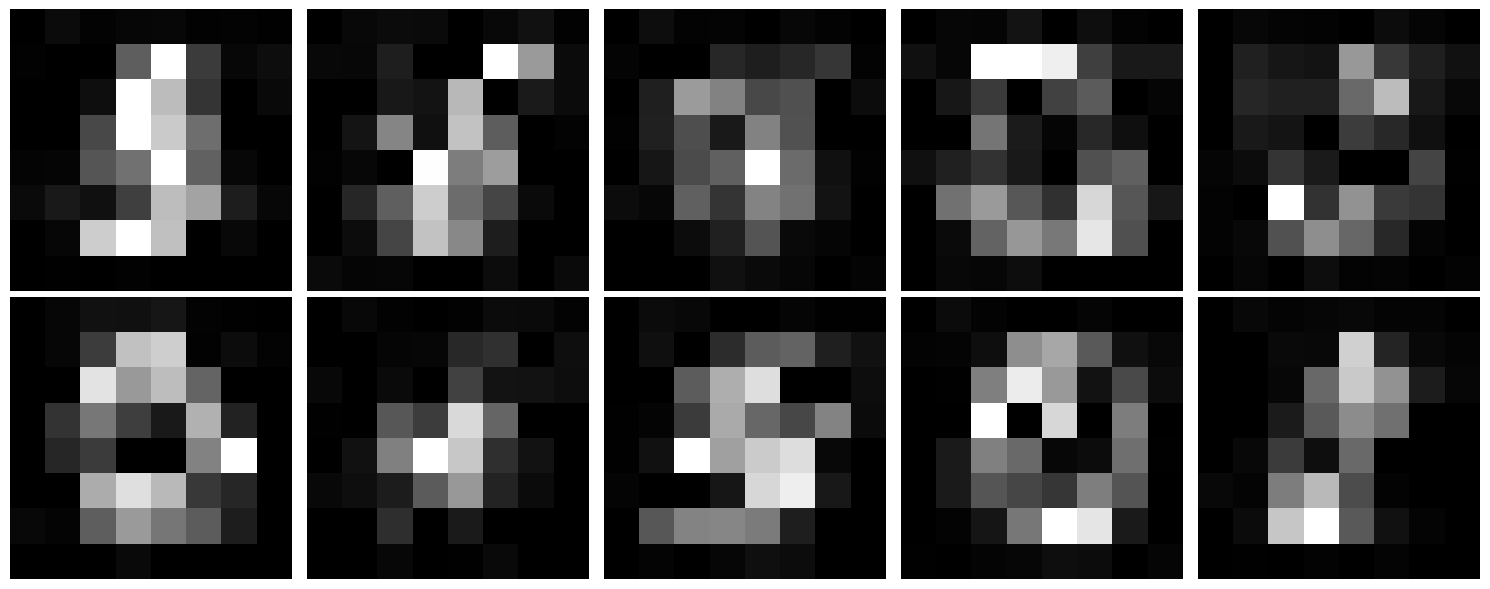

In [17]:
# n_reduced_timesteps = 5

sampler = VARSampler(policy_net, n_timesteps=n_reduced_timesteps, sample_shape=data_size, trainable_beta=False)
sampler = sampler.to(device)

sampler.eval()
d_sample = sampler.sample(10,device=device)
samples = d_sample['sample']

# Set up a 2x5 grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    img = samples[idx]
    # Clip the image tensor so values are within [0, 1]
    img = torch.clamp(img, -1, 1)
    img = ((img + 1) / 2 * 255).to(torch.uint8)

    # Permute dimensions from [C, H, W] to [H, W, C] for matplotlib
    img = img.permute(1, 2, 0)
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.axis('off')  # Remove axes ticks

plt.tight_layout()
plt.savefig(f'var_sampler_images_{now_str}.png')


In [18]:
score = compute_fid(None, None, device, sample_size=1000, sampler=sampler)
print(f"downsample FID: {score:.6f}")

score = compute_fid(policy_net, diffusion, device, sample_size=1000, sampler=None)
print(f"original FID: {score:.6f}")

downsample FID: 2.240639
original FID: 1.288106


In [19]:
def append_buffer(state_buffer, d_sample):
    x_seq = d_sample["l_sample"]
    n_sample = len(x_seq[0])
    n_seq = len(x_seq) - 1
    device = x_seq[0].device

    for t in range(n_seq):
        state_buffer["state"] = torch.cat((state_buffer["state"], x_seq[t].detach()))
        state_buffer["next_state"] = torch.cat(
            (state_buffer["next_state"], x_seq[t + 1].detach())
        )
        state_buffer["timestep"] = torch.cat(
            (state_buffer["timestep"], torch.tensor([t] * n_sample).to(device))
        )
        state_buffer["final"] = torch.cat((state_buffer["final"], x_seq[-1].detach()))
        if 'logp' in d_sample:
            logp = d_sample["logp"]
            state_buffer["logp"] = torch.cat((state_buffer["logp"], logp[t].detach()))
        if 'control' in d_sample:
            state_buffer["control"] = torch.cat((state_buffer["control"],
                                                 d_sample['control'][t].detach()))
        if 'entropy' in d_sample:
            state_buffer["entropy"] = torch.cat((state_buffer["entropy"],
                                                 d_sample['entropy'][t].detach()))
        if 'mean' in d_sample:
            state_buffer["mean"] = torch.cat((state_buffer["mean"],
                                                 d_sample['mean'][t].detach()))
        if 'sigma' in d_sample:
            state_buffer["sigma"] = torch.cat((state_buffer["sigma"],
                                                 d_sample['sigma'][t].detach()))
        if 'y' in d_sample:
            state_buffer["y"] = torch.cat((state_buffer["y"], d_sample["y"].detach()))
    return state_buffer


def reset_buffer(device):
    state_dict = {}
    state_dict['state'] = torch.FloatTensor().to(device)
    state_dict['next_state'] = torch.FloatTensor().to(device)
    state_dict['timestep'] = torch.LongTensor().to(device)
    state_dict['final'] = torch.FloatTensor().to(device)
    state_dict['logp'] = torch.FloatTensor().to(device)
    state_dict['control'] = torch.FloatTensor().to(device)
    state_dict['entropy'] = torch.FloatTensor().to(device)
    state_dict['mean'] = torch.FloatTensor().to(device)
    state_dict['sigma'] = torch.FloatTensor().to(device)
    state_dict["y"] = torch.LongTensor().to(device)
    return state_dict

In [20]:
# hidden_size_value = 512
# hidden_layers_value = 5

value_net = ValueNet(hidden_size=hidden_size_value, hidden_layers=hidden_layers_value, data_size=data_size).to(device)

# create target critic
import copy
value_net_target = copy.deepcopy(value_net)
# freeze target's gradients
for p in value_net_target.parameters():
    p.requires_grad = False

In [21]:
# learning_rate_policy = 1e-7
# learning_rate_value = 1e-6

optimizer_value  = optim.Adam(value_net.parameters(), lr=learning_rate_value)
optimizer_policy = optim.Adam(policy_net.parameters(), lr=learning_rate_policy)

In [22]:
def save_value_checkpoint(policy_net, value_net, epoch):
    checkpoint = {
        "policy_net_state_dict": policy_net.state_dict(),
        "diffusion_state_dict": diffusion.state_dict(),
        "hyperparameters": {
            "num_timesteps": num_timesteps,
            "embedding_size": embedding_size,
            "hidden_size": hidden_size,
            "hidden_layers": hidden_layers,
            "data_size": data_size,
            "limit_samples": limit_samples,
            "learning_rate": learning_rate,
            "train_batch_size": train_batch_size,
            "num_epochs": num_epochs,
            "device": device.type
        }
    }

    # Save the checkpoint to a file.
    save_path = f"policy_net_during_dxmi_e{epoch:05}_{now_str}.pt"
    torch.save(checkpoint, save_path)

    checkpoint = {
        "value_net_state_dict": policy_net.state_dict(),
        "hyperparameters": {
            "n_reduced_timesteps": n_reduced_timesteps,
            "hidden_size_value": hidden_size_value,
            "hidden_layers_value": hidden_layers_value,
            "learning_rate_value": learning_rate_value,
            "learning_rate_policy": learning_rate_policy,
            "num_epochs": num_epochs,
            "data_size": data_size
        }
    }

    # Save the checkpoint to a file.
    save_path = f"value_net_during_e{epoch:05}_{now_str}.pt"
    torch.save(checkpoint, save_path)



In [23]:
def soft_update(online_net, target_net, tau=0.005):
    """
    Perform a soft (Polyak) update of target_net’s parameters toward online_net’s.

    Args:
      online_net (torch.nn.Module): the live network (e.g. value_net)
      target_net (torch.nn.Module): the target network (e.g. value_net_target)
      tau (float): interpolation factor in [0,1], e.g. 0.005
    """
    for param, param_target in zip(online_net.parameters(),
                                   target_net.parameters()):
        # target ← (1 - tau) * target + tau * online
        param_target.data.mul_(1.0 - tau)
        param_target.data.add_(tau * param.data)


In [24]:

def get_running_cost(state, next_state, pred_mean, pred_std, eps: float = 1e-8):
    """
    Stateless running‐cost: ½‖u‖²  where  u = (next_state - pred_mean) / pred_std.
    Returns a tensor of shape (B,) giving the mean‐per‐sample cost.
    """
    u = (next_state - pred_mean) / (pred_std + eps)
    return 0.5 * u.view(u.size(0), -1).pow(2).mean(dim=1)


In [25]:
import time


# --- Hyperparameters & logging setup ---
value_iteration_file = f"value_iteration_{now_str}.txt"

# num_epochs          = 1000
# target_network      = False
# entropy_coef        = 0.0   # τ₁
# cost_coef           = 0.1   # τ₂
# gradient_clipping   = 0.0

num_epochs        = dxmi_num_epochs
target_network    = dxmi_target_network
entropy_coef      = dxmi_entropy_coef
cost_coef         = dxmi_cost_coef
gradient_clipping = dxmi_gradient_clipping

hyperparams = {
    "n_reduced_timesteps": n_reduced_timesteps,
    "hidden_size_value":   hidden_size_value,
    "hidden_layers_value":  hidden_layers_value,
    "learning_rate_value":  learning_rate_value,
    "learning_rate_policy": learning_rate_policy,
    "num_epochs":           num_epochs,
    "target_network":       target_network,
    "entropy_coef":         entropy_coef,
    "cost_coef":            cost_coef,
    "gradient_clipping": gradient_clipping,
}

with open(log_file, "a") as f:
    f.write("=== Hyperparameters for value iteration ===\n")
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
    f.write("\n")
    f.flush()


# --- Training loop ---
for epoch in range(num_epochs):
    start_time = time.time()
    policy_net.train(); value_net.train()

    # metrics accumulators
    epoch_metrics = {
        "energy_loss":     0.0,
        "positive_energy": 0.0,
        "negative_energy": 0.0,
        "value_loss":      0.0,
        "policy_loss":     0.0,
        "entropy":         0.0,
        "running_cost":    0.0,
    }
    updates = {"energy": 0, "value": 0, "policy": 0}

    # refill replay buffer
    state_dict = reset_buffer(device)

    for (images,) in train_loader:
        # --- Energy update ---
        sampler.eval()
        images = images.to(device)
        d_sample = sampler.sample(len(images), device=device)
        append_buffer(state_dict, d_sample)

        x_seq = d_sample["l_sample"]
        x0 = x_seq[-1]
        inputs = torch.cat((images.detach(), x0.detach()), dim=0)
        out = value_net(inputs)
        pos_e, neg_e = out[:x0.shape[0]], out[x0.shape[0]:]

        d_loss = pos_e.mean() - neg_e.mean()
        optimizer_value.zero_grad()
        d_loss.backward()
        optimizer_value.step()

        epoch_metrics["energy_loss"]     += d_loss.item()
        epoch_metrics["positive_energy"] += pos_e.mean().item()
        epoch_metrics["negative_energy"] += neg_e.mean().item()
        updates["energy"] += 1

        # --- Value update (TD) ---
        n_steps   = n_reduced_timesteps
        batchsize = train_batch_size
        offset    = state_dict["state"].shape[0] - batchsize * n_steps

        for i in range(n_steps):
            start = (n_steps - i - 1) * batchsize + offset
            end   = (n_steps - i)     * batchsize + offset
            s  = state_dict["state"][start:end]
            ns = state_dict["next_state"][start:end]

            if target_network:
                # Use the target for TD bootstrapping
                with torch.no_grad():
                    tgt = value_net_target(ns).squeeze()
            else:
                tgt = value_net(ns).squeeze()

            v_xt   = value_net(s).squeeze()
            v_loss = F.mse_loss(v_xt, tgt.detach())

            optimizer_value.zero_grad()
            v_loss.backward()
            optimizer_value.step()

            epoch_metrics["value_loss"] += v_loss.item()
            updates["value"] += 1

            if target_network:
                # update target
                soft_update(value_net, value_net_target, tau=0.005)


        # --- Policy update (with entropy & running cost) ---
        sampler.train()
        permutation = torch.randperm(state_dict["state"].shape[0])
        n_data      = min(len(permutation), batchsize)

        for m in range(0, n_data, batchsize):
            idx = permutation[m : m + batchsize]
            s = state_dict["state"][idx]
            t = state_dict["timestep"][idx]

            dss = sampler.sample_step(s, t)
            ns  = dss["sample"]
            μ   = dss["mean"]
            σ   = dss["sigma"]

            # value-based part
            pvl = value_net(ns).mean()

            # running cost
            rc = get_running_cost(s, ns, μ, σ)

            # This is often done because you don’t want to
            # penalize control effort or entropy at the final step when you’re “finishing” the trajectory.
            non_term = (t < n_reduced_timesteps - 1).float()

            # entropy bonus
            ent = σ.squeeze().log()

            # combined loss
            loss = (
                pvl
                + cost_coef    * rc  * non_term
                - entropy_coef * ent * non_term
            ).mean()

            optimizer_policy.zero_grad()
            loss.backward()
            if gradient_clipping > 0.0:
                total_norm = torch.nn.utils.clip_grad_norm_(sampler.parameters(), gradient_clipping)
            optimizer_policy.step()

            epoch_metrics["policy_loss"]  += loss.item()
            epoch_metrics["entropy"]      += ent.mean().item()
            epoch_metrics["running_cost"] += rc.mean().item()
            updates["policy"] += 1

    # --- Compute averages & log ---
    avg = {
        "energy_loss":     epoch_metrics["energy_loss"]     / updates["energy"],
        "positive_energy": epoch_metrics["positive_energy"] / updates["energy"],
        "negative_energy": epoch_metrics["negative_energy"] / updates["energy"],
        "value_loss":      epoch_metrics["value_loss"]      / updates["value"],
        "policy_loss":     epoch_metrics["policy_loss"]     / updates["policy"],
        "entropy":         epoch_metrics["entropy"]         / updates["policy"],
        "running_cost":    epoch_metrics["running_cost"]    / updates["policy"],
    }

    total_time = time.time() - start_time
    fid_score  = compute_fid(None, None, device=device, sampler=sampler)

    output_line = (
        f"Epoch {epoch+1}/{num_epochs} took {total_time:.2f}s, "
        f"Energy Loss: {avg['energy_loss']:.6f}, "
        f"Value Loss: {avg['value_loss']:.6f}, "
        f"Policy Loss: {avg['policy_loss']:.6f}, "
        f"Entropy: {avg['entropy']:.6f}, "
        f"Running Cost: {avg['running_cost']:.6f}, "
        f"Positive Energy: {avg['positive_energy']:.6f}, "
        f"Negative Energy: {avg['negative_energy']:.6f}, "
        f"FID: {fid_score:.6f}"
    )
    print(output_line)
    with open(value_iteration_file, "a") as f:
        f.write(output_line + "\n")
        f.flush()


Epoch 1/10 took 8.00s, Energy Loss: -0.300601, Value Loss: 1.933304, Policy Loss: 4.365587, Entropy: -2.942267, Running Cost: 0.500162, Positive Energy: 4.512475, Negative Energy: 4.813076, FID: 2.596737
Epoch 2/10 took 8.37s, Energy Loss: -0.276359, Value Loss: 5.185423, Policy Loss: 8.872406, Entropy: -2.935073, Running Cost: 0.500491, Positive Energy: 9.187997, Negative Energy: 9.464356, FID: 2.339355
Epoch 3/10 took 7.89s, Energy Loss: -0.186854, Value Loss: 4.954916, Policy Loss: 10.510052, Entropy: -2.952008, Running Cost: 0.499737, Positive Energy: 10.733221, Negative Energy: 10.920075, FID: 2.746664
Epoch 4/10 took 7.93s, Energy Loss: -0.141989, Value Loss: 3.521940, Policy Loss: 11.413683, Entropy: -2.947683, Running Cost: 0.499237, Positive Energy: 11.569769, Negative Energy: 11.711758, FID: 2.785339
Epoch 5/10 took 7.38s, Energy Loss: -0.118377, Value Loss: 2.227380, Policy Loss: 12.040941, Entropy: -2.978539, Running Cost: 0.500102, Positive Energy: 12.146550, Negative Ener

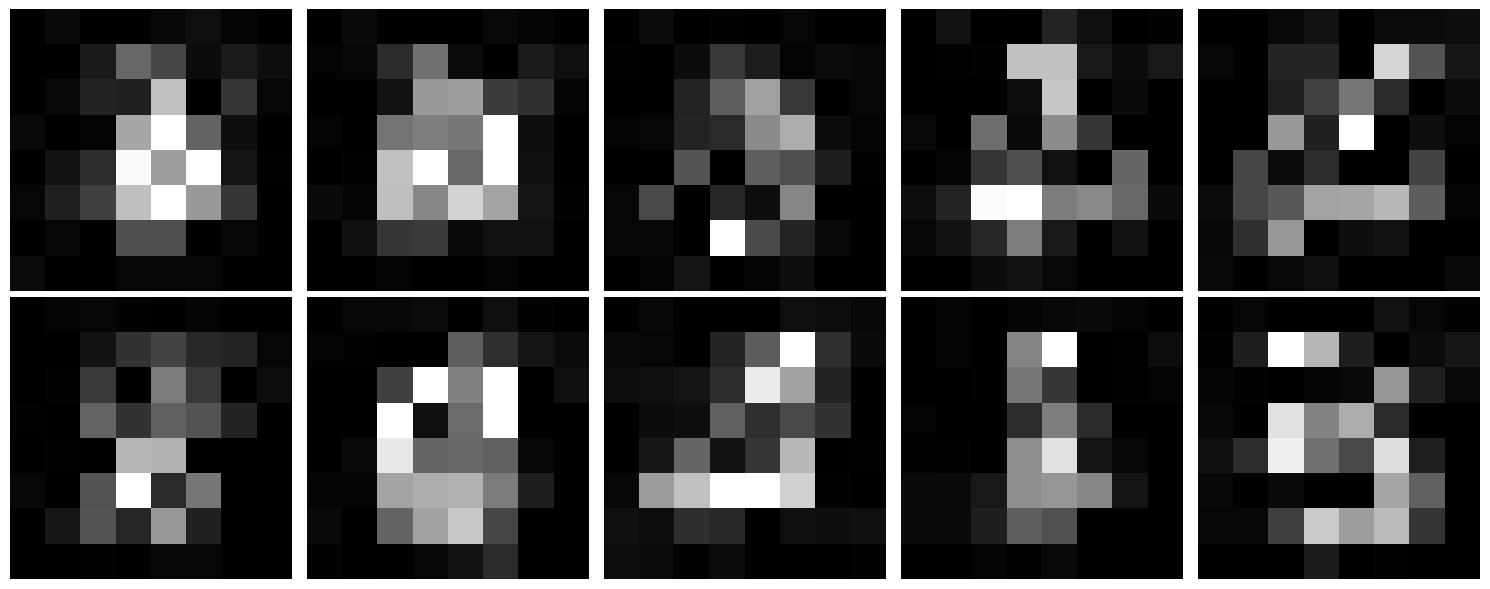

In [26]:
sampler.eval()
d_sample = sampler.sample(10,device=device)

samples = d_sample['sample']

# Set up a 2x5 grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    img = samples[idx]
    # Clip the image tensor so values are within [0, 1]
    img = torch.clamp(img, -1, 1)
    img = ((img + 1) / 2 * 255).to(torch.uint8)

    # Permute dimensions from [C, H, W] to [H, W, C] for matplotlib
    img = img.permute(1, 2, 0)
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.axis('off')  # Remove axes ticks

plt.tight_layout()
plt.savefig(f'value_iteration_images_{now_str}.png')
